# Step 7: Performance interpretability: 

In [1]:
%cd ..
from src import data_utils, model_utils
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mlxtend.evaluate import feature_importance_permutation
import XPER
from XPER.compute.Performance import ModelPerformance
from codecarbon import EmissionsTracker

/Users/samuelberrebi/Desktop/Projects/DsB/Explainability/Interpretable-jimams


## Import data and model

In [2]:
tracker = EmissionsTracker()

raw_data = pd.read_csv("data/data_clean.csv")
df_one_hot = data_utils.preprocess_data(raw_data)
X, y = df_one_hot.drop('y', axis=1), df_one_hot['y']
X_train, X_test, y_train, y_test = data_utils.split_data(X, y)

[codecarbon INFO @ 15:03:25] [setup] RAM Tracking...
[codecarbon INFO @ 15:03:25] [setup] GPU Tracking...
[codecarbon INFO @ 15:03:25] No GPU found.
[codecarbon INFO @ 15:03:25] [setup] CPU Tracking...
[codecarbon WARNING @ 15:03:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:03:25] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon INFO @ 15:03:25] CPU Model on constant consumption mode: Apple M2
[codecarbon INFO @ 15:03:25] >>> Tracker's metadata:
[codecarbon INFO @ 15:03:25]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 15:03:25]   Python version: 3.10.10
[codecarbon INFO @ 15:03:25]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 15:03:25]   Available RAM : 16.000 GB
[codecarbon INFO @ 15:03:25]   CPU count: 8
[codecarbon INFO @ 15:03:25]   CPU model: Apple M2
[codecarbon INFO @ 15:03:25]   GPU count: None
[codecarbon INFO @ 15:03:25]   GPU model: None


In [3]:
# Load the model from the .pkl file
model_xgb = pickle.load(open("model/model.pkl", "rb"))

## Importance permutation

### First try with mlxtend

In [4]:
# Regroup one hot encoded fetaures
feature_group = [0, 1, 2, 3, 4, 5, 6, 7,
     range(8, 15),  # Race / ethnicity
    range(15, 20),   # Crime 1 - Class (columns 15-19)
    range(20, 25),   # Crime 2 - Class (columns 20-24)
    range(25, 30),   # Crime 3 - Class (columns 25-29)
    range(30, 35),   # Crime 4 - Class (columns 30-34)
    range(35, 38)]

feature_names = [
    'parole board interview date', 'parole eligibility date',
       'min_sentence', 'max_sentence', 'count of crimes', 'age',
       'jail duration', 'sex',
    'Race / Ethnicity',
    'Crime 1 - Class',
    'Crime 2 - Class',
    'Crime 3 - Class',
    'Crime 4 - Class',
    'Parole Board Interview Type'
]

##### Test set

In [5]:
# Ensure that the data is in the correct format (NumPy arrays)
X_test_1 = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_test_1 = y_test.values if isinstance(y_test, pd.Series) else y_test


In [6]:
# Compute featute importance permutation

imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_xgb.predict, 
    X=X_test_1,
    y=y_test_1,
    metric='accuracy',
    num_rounds=1,
    seed=1,
    feature_groups=feature_group)

imp_vals

array([-0.00851017, -0.00099469, -0.01138373, -0.01204686,  0.00033156,
        0.00397878,  0.0224359 ,  0.00386826,  0.07117595,  0.0795756 ,
        0.06399204,  0.06918656,  0.06421309,  0.06752874])

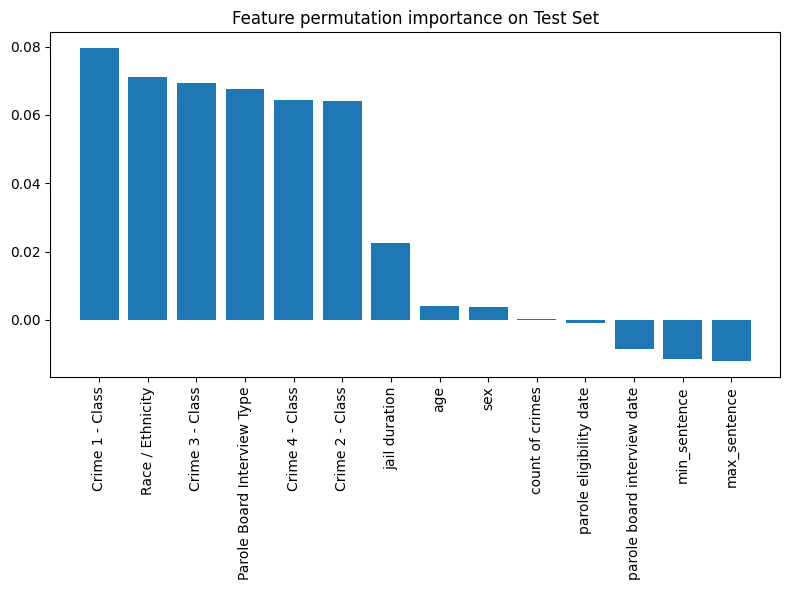

In [7]:
# Plot

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_names)), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(len(feature_names)),
           np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.title('Feature permutation importance on Test Set')
plt.show()

##### Train set

In [8]:
# Ensure that the data is in the correct format (NumPy arrays)
X_train_1 = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train_1 = y_train.values if isinstance(y_train, pd.Series) else y_train

In [9]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_xgb.predict, 
    X=X_train_1,
    y=y_train_1,
    metric='accuracy',
    num_rounds=1,
    seed=1,
    feature_groups=feature_group)

imp_vals

array([-0.00573215,  0.00156331, -0.00658487, -0.00909565,  0.00402672,
        0.01321711,  0.03102942,  0.00350561,  0.0829504 ,  0.08759297,
        0.08133971,  0.08432422,  0.08602966,  0.08726136])

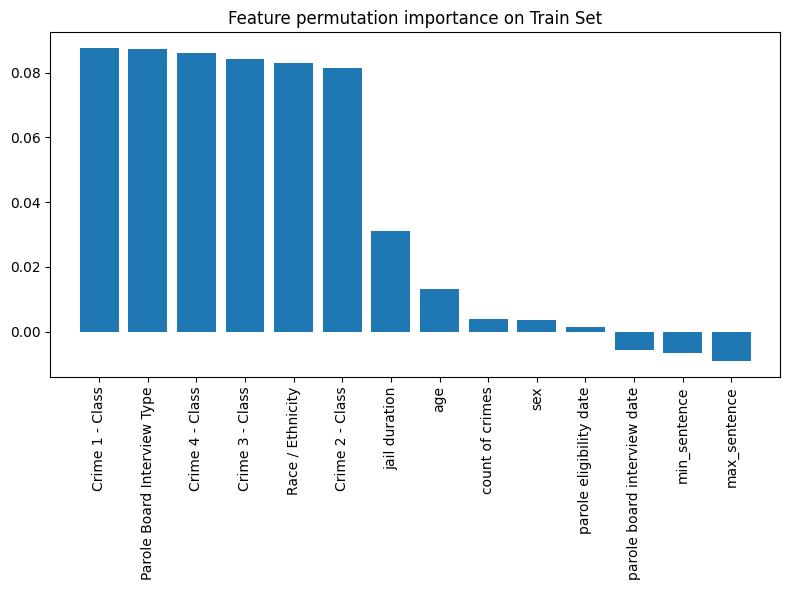

In [10]:
std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_names)), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(len(feature_names)),
           np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.title('Feature permutation importance on Train Set')
plt.show()

## XPER

In [11]:
df_sample = df_one_hot.sample(n=100)


X_train, X_test, y_train, y_test = train_test_split(df_sample.drop('y',axis=1), df_sample['y'], 
                                                    stratify=df_sample['y'], test_size=0.3, random_state=42)

In [12]:
# Define the evaluation metric(s) to be used
XPER = ModelPerformance(X_train, y_train, X_test, y_test, model_xgb, sample_size=100)

# Evaluate the model performance using the specified metric(s)
PM = XPER.evaluate(["AUC"])

# Print the performance metrics
print("Performance Metrics: ", round(PM, 3))

Performance Metrics:  0.776


In [13]:
# Option 1 - Kernel True
# Calculate XPER values for the model's performance
XPER_values = XPER.calculate_XPER_values(["AUC"])

Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

2124


Performing Computation: 100%|██████████| 1/1 [01:52<00:00, 112.01s/it]


In [15]:
import pandas as pd
from XPER.viz.Visualisation import visualizationClass as viz

labels = list(X_test.columns)

viz.bar_plot(XPER_values=XPER_values, X_test=pd.DataFrame(X_test), labels=labels, p=10 ,percentage=True)

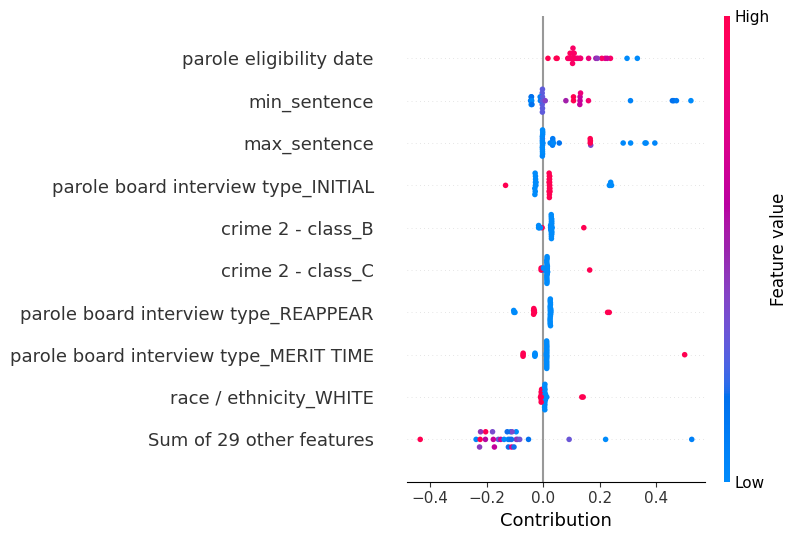

In [16]:
viz.beeswarn_plot(XPER_values=XPER_values,X_test=pd.DataFrame(X_test),labels=labels)

## With Accuracy

In [21]:
df_sample = df_one_hot.sample(n=500)


X_train, X_test, y_train, y_test = train_test_split(df_sample.drop('y',axis=1), df_sample['y'], 
                                                    stratify=df_sample['y'], test_size=0.3, random_state=42)

In [22]:
# Define the evaluation metric(s) to be used
XPER = ModelPerformance(X_train, y_train, X_test, y_test, model_xgb, sample_size=500)

# Evaluate the model performance using the specified metric(s)
PM = XPER.evaluate(["AUC"])

# Print the performance metrics
print("Performance Metrics: ", round(PM, 3))

Performance Metrics:  0.862


In [23]:
# Option 1 - Kernel True
# Calculate XPER values for the model's performance
XPER_values = XPER.calculate_XPER_values(["Accuracy"])

Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

2124


Performing Computation: 100%|██████████| 1/1 [01:32<00:00, 92.38s/it]


In [24]:
import pandas as pd
from XPER.viz.Visualisation import visualizationClass as viz

labels = list(X_test.columns)

viz.bar_plot(XPER_values=XPER_values, X_test=pd.DataFrame(X_test), labels=labels, p=10 ,percentage=True)

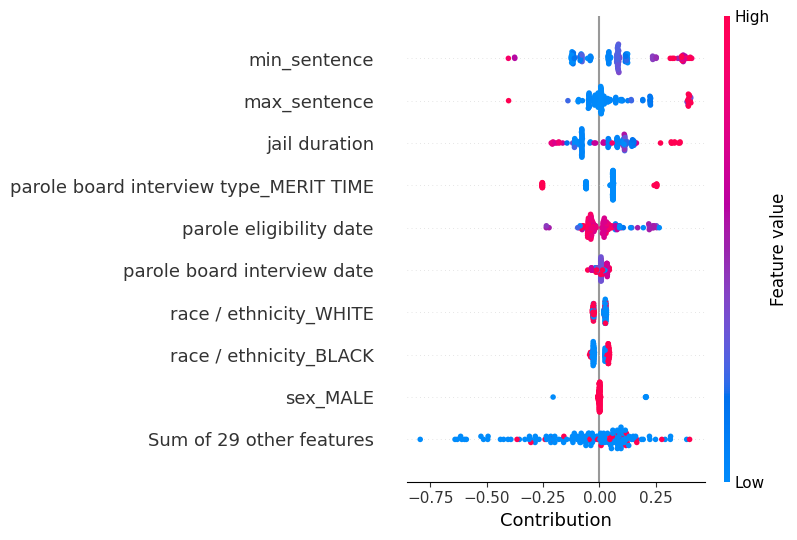

In [25]:
viz.beeswarn_plot(XPER_values=XPER_values,X_test=pd.DataFrame(X_test),labels=labels)